First of all, I am very keen on trying new methods. This is why I tried a meta-learning method in this project. In this technique, first I used a custom ConvMixer block based CNN model for the feature extraction stage, then applied PCA for the curse of dimensionality problem, and finally used a CatBoost model for the classification stage. 

In this dataset, there are several images of the same patient. It is a cautious issue when splitting data. If we directly shuffle and split this data, this will give rise to the overfitting problem, because our model saw the testing data. This is why I used the last 298 images for testing.

I dropped a feature named 'biopsed' because this feature is very correlated with the target variable. If I use this feature, the test accuracy is nearly 70 %.

<i><b>Version 2: </b> There was a problem with shuffling training data and I fixed it. I tried the 0.98 % variance ratio in the PCA stage. And I added the test set prediction examples. </i>

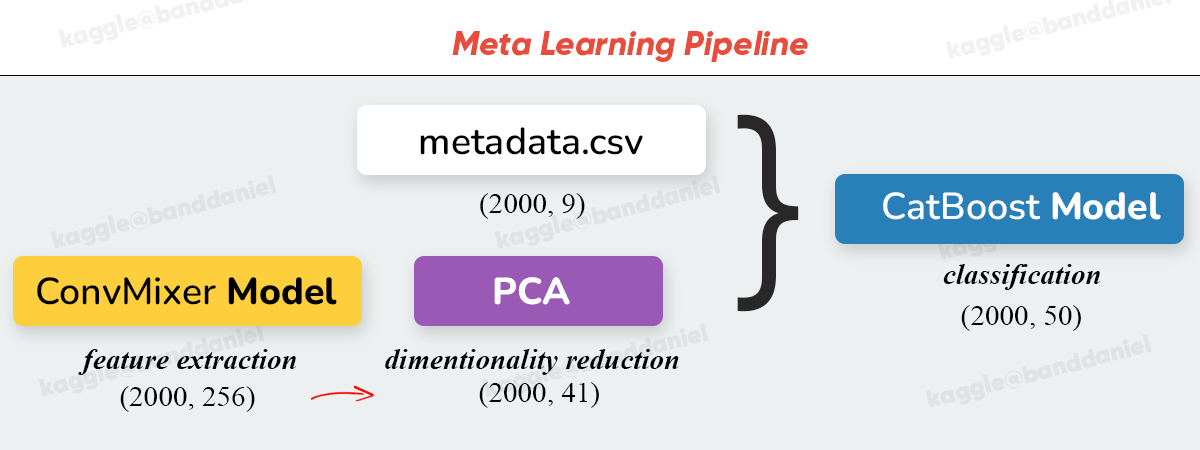



I have used the following methods.

* I used a model created with <b>ConvMixer </b> blocks [1,2],
* <b>gelu</b> activation function during the feature extraction stage,
* Used <b>tf.data</b> for input pipeline,
* I split the full data into train (2000 images) and test (298 images),


## My Another Projects
* [Jellyfish Detect (10CV Custom ConvMixer) (F1:0.87)](https://www.kaggle.com/code/banddaniel/jellyfish-detect-10cv-custom-convmixer-f1-0-87)
* [(76 GB) 160 Polish Bird Sounds Classification](https://www.kaggle.com/code/banddaniel/76-gb-160-polish-bird-sounds-classification)
* [Segment Medical Instrument, w/Custom DeepLabv3+(Dice: 0.86)](https://www.kaggle.com/code/banddaniel/segment-medical-instrument-deeplabv3-dice-0-86)
* [Rice Classification w/Custom ResNet50 (ACC 85%)](https://www.kaggle.com/code/banddaniel/rice-classification-w-custom-resnet50-acc-85)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)


## References
1. Trockman, A., & Kolter, J. Z. (2022). Patches Are All You Need? (Version 1). arXiv. https://doi.org/10.48550/ARXIV.2201.09792
2. https://keras.io/examples/vision/convmixer


In [1]:
# Importing dependencies

import os
import cv2
import shutil  
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier, Pool

import shap
shap.initjs()

IMG_SIZE = 32,32
BATCH_SIZE = 256
SEED = 55
AUTO = tf.data.AUTOTUNE

In [2]:
# Creating new directory for full images

os.mkdir('/kaggle/working/full_images')

In [3]:
# Moving all images to new directory

def move_to_images(path, dest_dir):
    images = sorted(os.listdir(path))
    for i in images:
        try:
            shutil.move(os.path.join(path, i), dest_dir)
        except OSError:
            pass
        
        
move_to_images('/kaggle/input/skin-cancer/imgs_part_1/imgs_part_1', '/kaggle/working/full_images')
move_to_images('/kaggle/input/skin-cancer/imgs_part_2/imgs_part_2', '/kaggle/working/full_images')
move_to_images('/kaggle/input/skin-cancer/imgs_part_3/imgs_part_3', '/kaggle/working/full_images')

# <span style="color:#e74c3c;"> Reading </span> Data

In [4]:
# Reading metadata file
data = pd.read_csv('/kaggle/input/skin-cancer/metadata.csv')
data.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,NaN,NEV,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,5.0,BCC,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,...,NaN,ACK,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,...,NaN,ACK,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,5.0,BCC,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,PAT_684_1302_588.png,True


In [5]:
# Creating full links of images 
data['full_link'] = '/kaggle/working/full_images/' + data['img_id']

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           2298 non-null   object 
 1   lesion_id            2298 non-null   int64  
 2   smoke                1494 non-null   object 
 3   drink                1494 non-null   object 
 4   background_father    1480 non-null   object 
 5   background_mother    1476 non-null   object 
 6   age                  2298 non-null   int64  
 7   pesticide            1494 non-null   object 
 8   gender               1494 non-null   object 
 9   skin_cancer_history  1494 non-null   object 
 10  cancer_history       1494 non-null   object 
 11  has_piped_water      1494 non-null   object 
 12  has_sewage_system    1494 non-null   object 
 13  fitspatrick          1494 non-null   float64
 14  region               2298 non-null   object 
 15  diameter_1           1494 non-null   f

# <span style="color:#e74c3c;"> Preprocessing </span> 

In [7]:
# look-up table
diagnostic_classes = {0:'BCC', 1 : 'ACK', 2 : 'NEV', 3 : 'SEK', 4 : 'SCC', 5: 'MEL'}

# a function for encoding classes
def create_class(X):
    if X == 'BCC':
        return 0
    elif X =='ACK':
        return 1
    elif X == 'NEV':
        return 2
    elif X == 'SEK':
        return 3
    elif X == 'SCC':
        return 4
    elif X == 'MEL':
        return 5
    else:
        print('error class')

        
        
        
# applying the function and dropped 'diagnostic' feature because of this can lead to overfit (the target leakage problem)

data['encoded_class'] = data['diagnostic'].apply(create_class)
data.drop(['diagnostic'], axis = 1, inplace = True)
data.sort_values(by ='patient_id', ascending = True, inplace = True, ignore_index = True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           2298 non-null   object 
 1   lesion_id            2298 non-null   int64  
 2   smoke                1494 non-null   object 
 3   drink                1494 non-null   object 
 4   background_father    1480 non-null   object 
 5   background_mother    1476 non-null   object 
 6   age                  2298 non-null   int64  
 7   pesticide            1494 non-null   object 
 8   gender               1494 non-null   object 
 9   skin_cancer_history  1494 non-null   object 
 10  cancer_history       1494 non-null   object 
 11  has_piped_water      1494 non-null   object 
 12  has_sewage_system    1494 non-null   object 
 13  fitspatrick          1494 non-null   float64
 14  region               2298 non-null   object 
 15  diameter_1           1494 non-null   f

In [9]:
# dropped all features contain null element and 'biopsed' feature 

data.drop([ 'biopsed','patient_id', 'img_id','lesion_id','smoke', 'drink', 'background_father', 'background_mother', 'pesticide', 'gender', 'skin_cancer_history',
         'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'diameter_1', 'diameter_2'], axis = 1, inplace = True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            2298 non-null   int64 
 1   region         2298 non-null   object
 2   itch           2298 non-null   object
 3   grew           2298 non-null   object
 4   hurt           2298 non-null   object
 5   changed        2298 non-null   object
 6   bleed          2298 non-null   object
 7   elevation      2298 non-null   object
 8   full_link      2298 non-null   object
 9   encoded_class  2298 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 179.7+ KB


# <span style="color:#e74c3c;"> Creating </span> Train, Test Set

In [11]:
train_data = data[:2000]
test_data = data[2000:]
test_data = shuffle(test_data, random_state = SEED).reset_index(drop = True)

print('train  ->', train_data.shape)
print('test  ->', test_data.shape)

train  -> (2000, 10)
test  -> (298, 10)


In [12]:
counts = np.bincount(train_data['encoded_class'])

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]
weight_for_2 = 1.0 / counts[2]
weight_for_3 = 1.0 / counts[3]
weight_for_4 = 1.0 / counts[4]
weight_for_5 = 1.0 / counts[5]

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4, 5: weight_for_5}
class_weight

{0: 0.001440922190201729,
 1: 0.0015220700152207,
 2: 0.004273504273504274,
 3: 0.0045045045045045045,
 4: 0.0064516129032258064,
 5: 0.02631578947368421}

# <span style="color:#3498db;"> Feature Extraction </span>

# <span style="color:#e74c3c;"> Creating </span> Custom ConvMixer Layer

In [13]:
class ConvMixerBlock(Layer):
    def __init__(self, filters, kernel_size, patch_size, **kwargs):
        super(ConvMixerBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        
        self.deepwise = DepthwiseConv2D(kernel_size = kernel_size, padding = 'same')
        self.conv1 = Conv2D(filters, kernel_size = 1)
        self.act = Activation('gelu')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        X = self.deepwise(inputs)
        X = self.act(X)
        X = self.bn1(X)
        X = Add()([X, inputs])
        X = self.conv1(X)
        X = self.act(X)
        X = self.bn2(X)
            
        return X
      
    
    def get_config(self):
        base_config = super().get_config()
        
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "patch_size": self.patch_size}

# <span style="color:#e74c3c;"> Feature Extractor </span> Model

In [14]:
FEATURES = 256
inp = Input(shape = (*IMG_SIZE, 3))

X = Conv2D(FEATURES, 2, 2)(inp)
X = Activation('gelu')(X)
X = BatchNormalization()(X)

X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_1')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_2')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_3')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_4')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_5')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_6')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_7')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_8')(X)

X = GlobalAveragePooling2D(name = 'the_last_pooling_layer')(X)

out = Dense(6, activation = 'softmax')(X)


model = Model(inputs = inp, outputs = out)
model.summary()
    
model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001,weight_decay = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None) ] )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       3328      
                                                                 
 activation (Activation)     (None, 16, 16, 256)       0         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 256)      1024      
 ormalization)                                                   
                                                                 
 CONVMIXER_1 (ConvMixerBlock  (None, 16, 16, 256)      74496     
 )                                                               
                                                                 
 CONVMIXER_2 (ConvMixerBlock  (None, 16, 16, 256)      74496 

# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [15]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label


# Basic data augmentation 
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image)
    img = tf.image.random_flip_up_down(img)
    return img, label

In [16]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data['full_link'], train_data['encoded_class']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(augmentation, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .shuffle(BATCH_SIZE*10)
                 .prefetch(AUTO))

# Train dataset without shuffle and augmentation
train_loader_for_feature = tf.data.Dataset.from_tensor_slices((train_data['full_link'], train_data['encoded_class']))
train_dataset_for_feature = (train_loader_for_feature
                             .map(img_preprocessing, num_parallel_calls = AUTO)
                             .batch(BATCH_SIZE)
                             .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_data['full_link'], test_data['encoded_class']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

In [17]:
# Training feature extraction model and saved

hist = model.fit(train_dataset, batch_size = BATCH_SIZE, epochs = 75, class_weight = class_weight, verbose = 0)
model.save("convmixer_feature_extractor.h5")

# <span style="color:#e74c3c;"> Classification </span> Stage

In [18]:
feature_extr = tf.keras.models.load_model('/kaggle/working/convmixer_feature_extractor.h5', 
                                         custom_objects={"ConvMixerBlock": ConvMixerBlock })


# Feature extraction model 
feature_extractor_model = Model(inputs=feature_extr.input, outputs=feature_extr.get_layer('the_last_pooling_layer').output)

In [19]:
pred = feature_extractor_model.predict(train_dataset_for_feature)

8/8 [==============================] - 23s 3s/step


In [20]:
# Applying PCA 41 components nearly equal to 0.98 variance ratio

pca_ = PCA(41)
pred_pca = pca_.fit_transform(pred)

new_feature_column_names = []
for i in range(pred_pca.shape[1]):
    new_feature_column_names.append('feature_{0}'.format(i+1))
    
pred_pca = pd.DataFrame(pred_pca, columns = new_feature_column_names)


# Features created with ConvMixer feature extractor 
pred_pca.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41
0,1.932353,1.296200,0.720419,-0.899794,-0.175435,-0.872021,-1.081020,-0.049611,0.948376,-0.775415,...,-0.059108,-0.210543,0.198411,-0.011271,-0.302473,0.069112,0.001954,-0.007021,-0.061192,0.080009
1,-4.364982,1.191646,0.662377,0.498867,2.294151,1.534149,1.171406,-0.430597,0.075155,-0.321364,...,0.330146,-0.026966,0.003501,-0.012695,0.087106,0.199339,0.131051,-0.093399,0.003974,0.021806
2,1.474414,2.383702,-1.209944,-0.195646,0.247089,0.702425,0.652568,-0.023139,-0.840758,0.090566,...,0.069571,-0.122680,-0.142308,0.014610,-0.125054,-0.202515,-0.010709,0.064253,0.106314,-0.021205
3,-0.495205,-2.437191,0.724422,-1.557408,-1.347825,0.741188,0.939692,0.425967,-0.690477,-0.293552,...,-0.061354,0.072184,-0.038002,0.295480,0.195375,0.181392,-0.177715,0.127086,0.080898,0.077489
4,-3.526074,0.141475,0.763352,-0.693282,0.101085,-0.481994,0.378444,-0.166070,0.054424,-0.942764,...,-0.190958,0.252406,-0.027171,-0.057752,-0.066749,0.003544,0.078602,-0.053951,-0.007178,0.065830


In [21]:
# Merging the deep learning features with meta data features

train_data_last = pd.concat([train_data, pred_pca], axis = 1)
train_data_last.drop(['full_link'], axis = 1, inplace = True)
train_data_last.head()

,age,region,itch,grew,hurt,changed,bleed,elevation,encoded_class,feature_1,...,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41
0,69,ARM,TRUE,UNK,FALSE,UNK,FALSE,TRUE,4,1.932353,...,-0.059108,-0.210543,0.198411,-0.011271,-0.302473,0.069112,0.001954,-0.007021,-0.061192,0.080009
1,14,FACE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,2,-4.364982,...,0.330146,-0.026966,0.003501,-0.012695,0.087106,0.199339,0.131051,-0.093399,0.003974,0.021806
2,14,FACE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,2,1.474414,...,0.069571,-0.122680,-0.142308,0.014610,-0.125054,-0.202515,-0.010709,0.064253,0.106314,-0.021205
3,65,EAR,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,3,-0.495205,...,-0.061354,0.072184,-0.038002,0.295480,0.195375,0.181392,-0.177715,0.127086,0.080898,0.077489
4,63,FOREARM,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,1,-3.526074,...,-0.190958,0.252406,-0.027171,-0.057752,-0.066749,0.003544,0.078602,-0.053951,-0.007178,0.065830


In [22]:
# Splitting features and target 

y_train_data_last = train_data_last.pop('encoded_class')
X_train_data_last = train_data_last

print('catboost train shape ->', X_train_data_last.shape)

catboost train shape -> (2000, 49)


In [23]:
# Creating train pool for the catboost model

cat_features = ['region', 'itch', 'grew', 'hurt', 'changed','bleed', 'elevation']
train_pool = Pool(X_train_data_last, y_train_data_last, cat_features = cat_features)

# <span style="color:#e74c3c;"> Classification Catboost </span> Model

In [24]:
cat_model = CatBoostClassifier(verbose = 250)
cat_model.fit(train_pool)

Learning rate set to 0.081974
0:	learn: 1.6667186	total: 142ms	remaining: 2m 22s
250:	learn: 0.3354162	total: 22.6s	remaining: 1m 7s
500:	learn: 0.1818424	total: 44.9s	remaining: 44.8s
750:	learn: 0.1112328	total: 1m 6s	remaining: 22.2s
999:	learn: 0.0737314	total: 1m 29s	remaining: 0us


In [25]:
# Test set processing
# test feature exteaction -> applying PCA -> merging with metadata -> predictions of the catboost model

test_pred = feature_extractor_model.predict(test_dataset)

test_pred_pca = pca_.fit_transform(test_pred)
test_pred_pca = pd.DataFrame(test_pred_pca, columns = new_feature_column_names)

test_data_last = pd.concat([test_data, test_pred_pca], axis = 1)
test_data_last.drop(['full_link'], axis = 1, inplace = True)

y_test_data_last = test_data_last.pop('encoded_class')
X_test_data_last = test_data_last


test_pool = Pool(X_test_data_last, y_test_data_last, cat_features = cat_features)
pred_cat_test = cat_model.predict(test_pool)

2/2 [==============================] - 3s 556ms/step


# <span style="color:#e74c3c;"> Test  </span> Results

In [26]:
# Predictions and scores

mse = mean_squared_error(y_test_data_last, pred_cat_test)
acc = accuracy_score(y_test_data_last, pred_cat_test)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Accuracy Score : {0:.2f} %'.format(acc*100))

Mean Squared Error : 2.90604
Accuracy Score : 65.77 %


# <span style="color:#e74c3c;"> Test Classification </span> Report

In [27]:
clf = classification_report(y_test_data_last, pred_cat_test, target_names = list(diagnostic_classes.values()))
print(clf)

              precision    recall  f1-score   support

         BCC       0.71      0.85      0.78       151
         ACK       0.85      0.70      0.77        73
         NEV       0.21      0.50      0.29        10
         SEK       0.43      0.77      0.56        13
         SCC       0.11      0.03      0.04        37
         MEL       0.00      0.00      0.00        14

    accuracy                           0.66       298
   macro avg       0.39      0.47      0.41       298
weighted avg       0.61      0.66      0.62       298



# <span style="color:#e74c3c;"> Test Confusion </span> Matrix

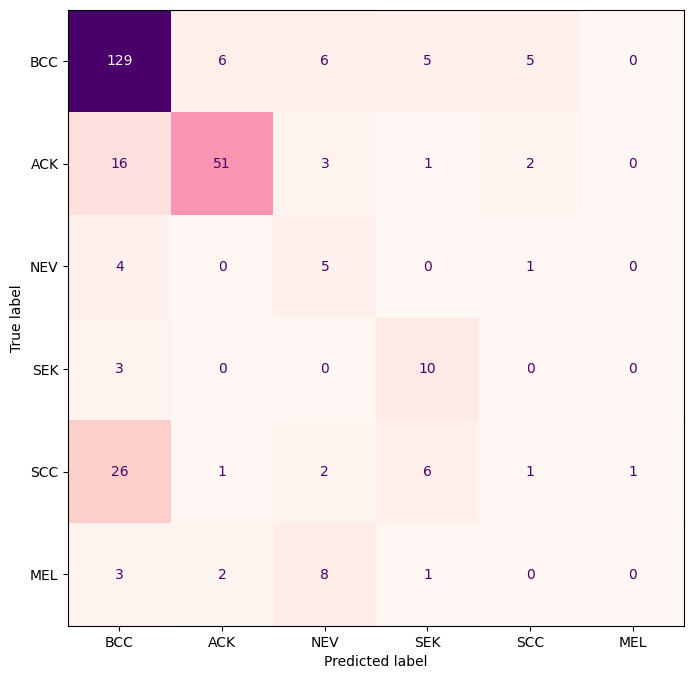

In [28]:
cm = confusion_matrix(y_test_data_last, pred_cat_test)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(diagnostic_classes.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax,  cmap = 'RdPu', colorbar = False)

# <span style="color:#e74c3c;"> Test </span> Predictions

In [29]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(pred_cat_test))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        img = cv2.cvtColor(img.numpy(), cv2.COLOR_BGR2GRAY)
        
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(pred_cat_test[idx[i]]) == label:
            axs[i].imshow(img, cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + diagnostic_classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img,  cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + diagnostic_classes[label], fontsize = 8, color = 'red')

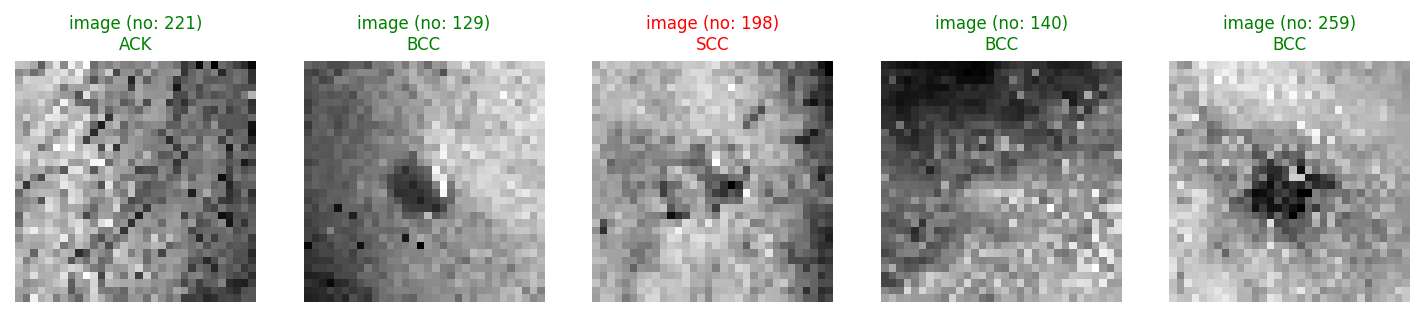

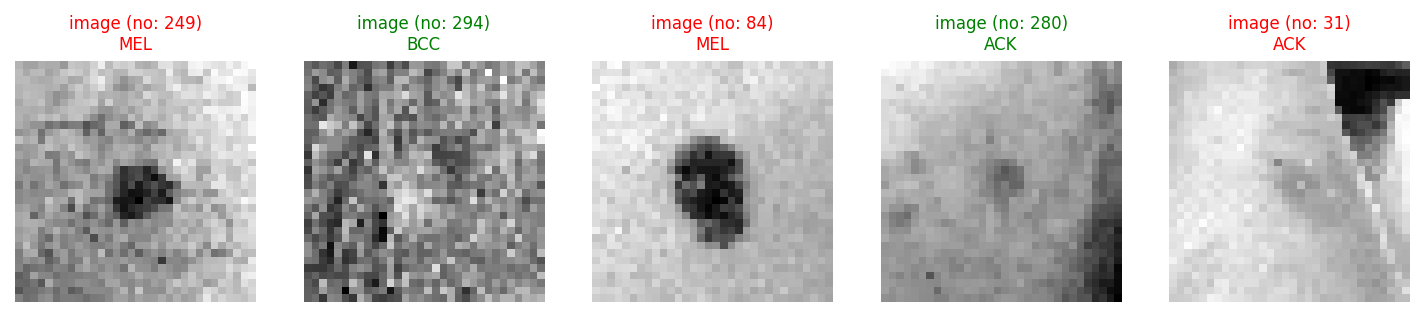

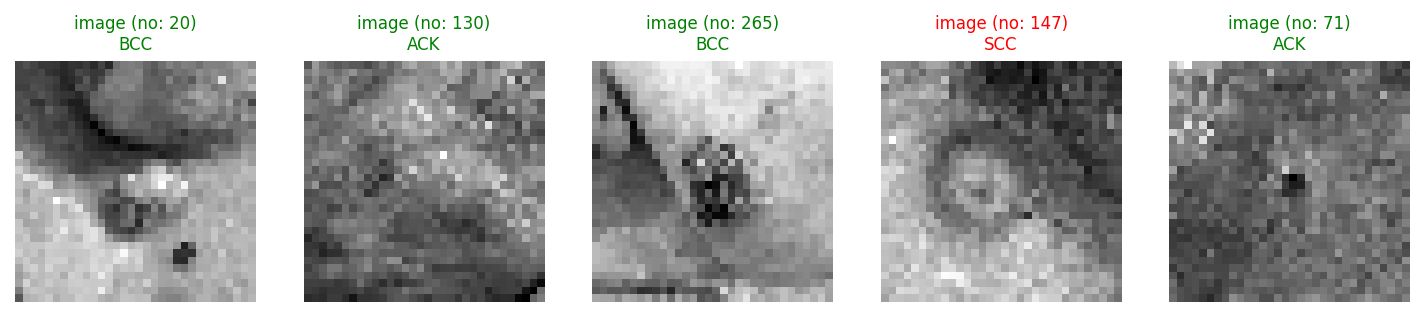

In [30]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 10)
random_test_sample_with_prediction(SEED = 20)
random_test_sample_with_prediction(SEED = 30)

# <span style="color:#e74c3c;"> Feature Explanation </span> w/SHAP

In [31]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer(pd.DataFrame(X_test_data_last, columns = X_test_data_last.columns))

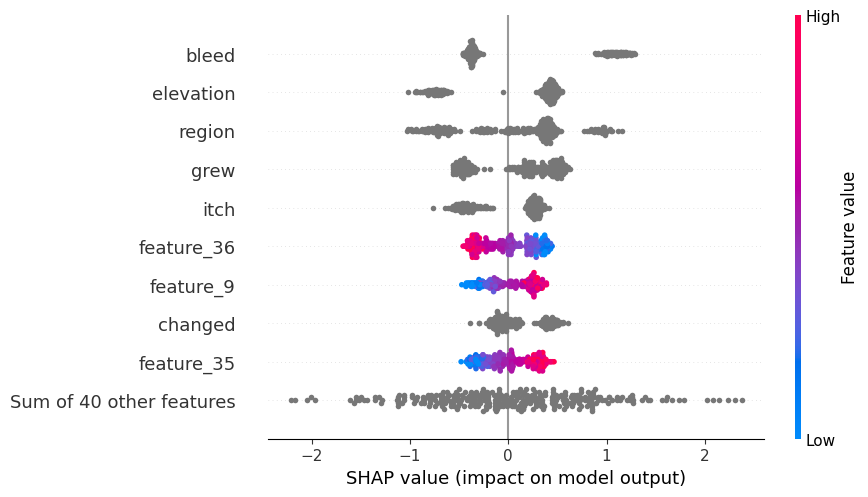

In [32]:
# BCC class feature explanation
shap.plots.beeswarm(shap_values[..., 0])

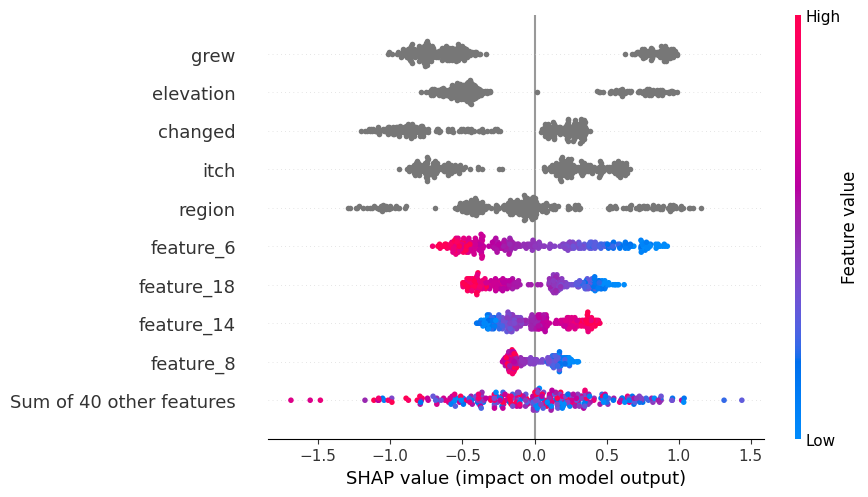

In [33]:
# ACK class feature explanation
shap.plots.beeswarm(shap_values[..., 1])

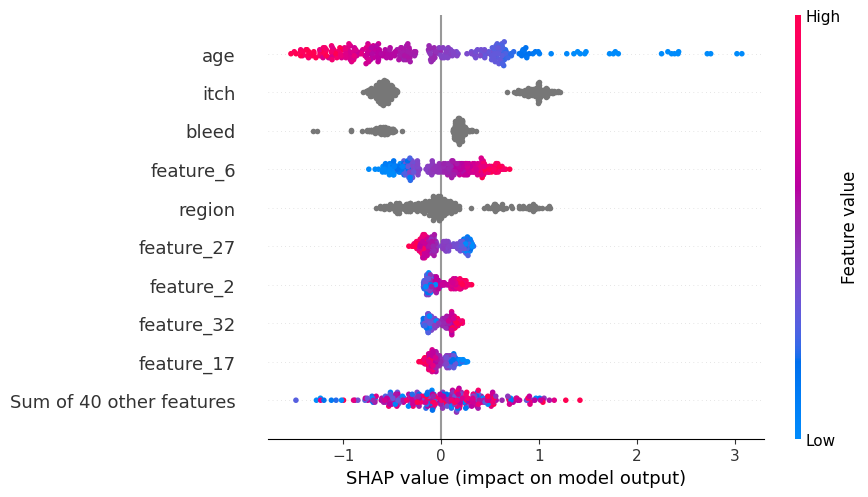

In [34]:
# NEV class feature explanation
shap.plots.beeswarm(shap_values[..., 2])

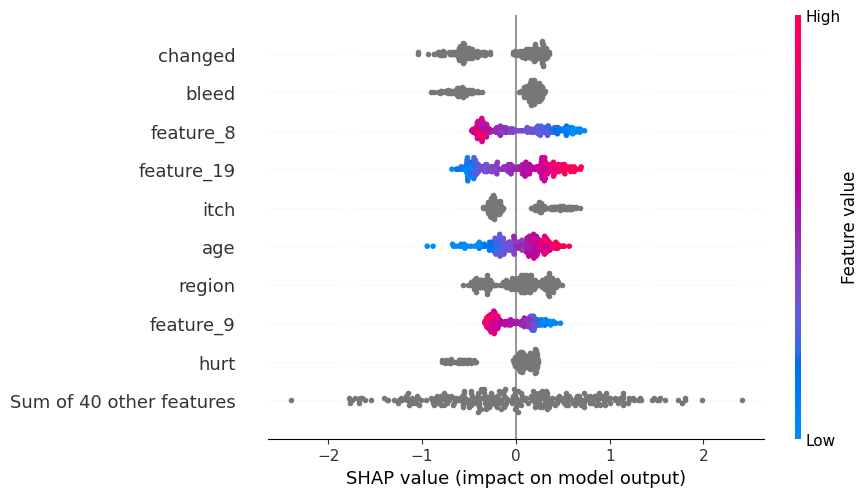

In [35]:
# SEK class feature explanation
shap.plots.beeswarm(shap_values[..., 3])

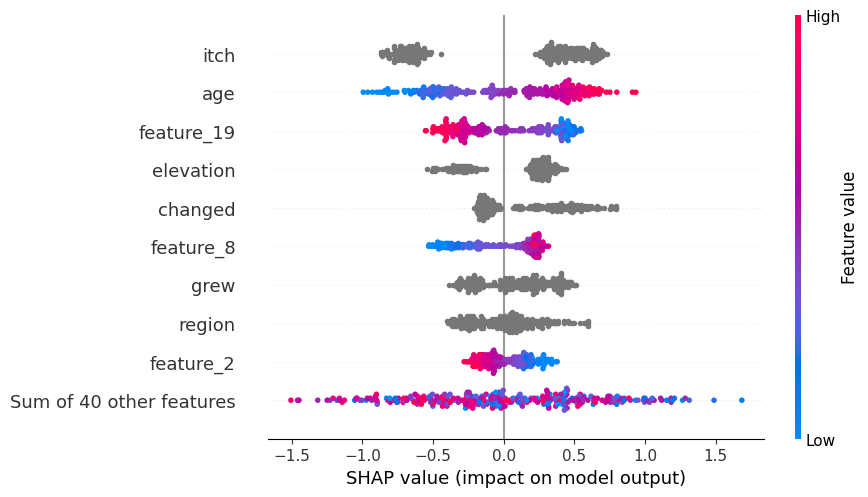

In [36]:
# SCC class feature explanation
shap.plots.beeswarm(shap_values[..., 4])

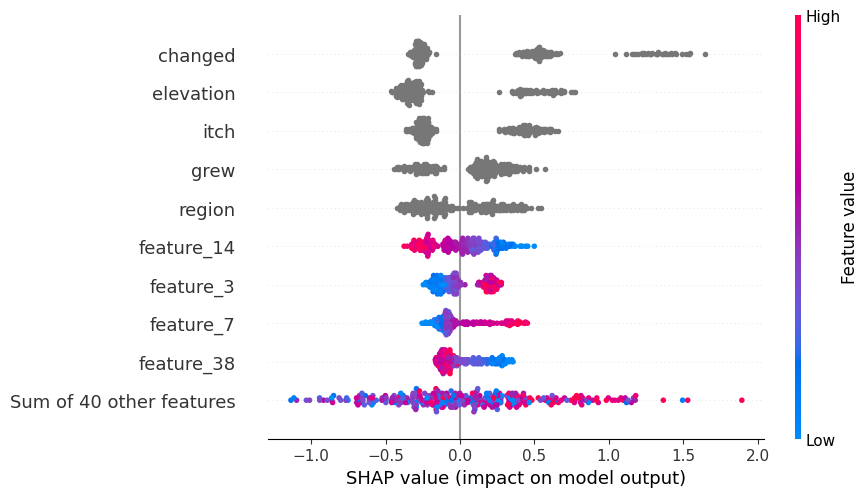

In [37]:
# MEL class feature explanation
shap.plots.beeswarm(shap_values[..., 5])